# CompleteDataSet Timestamp and Right Pocket Sensor Analysis

This notebook provides a comprehensive analysis of the timestamp patterns and right pocket sensor data from the CompleteDataSet.csv file, focusing on sampling rate analysis, temporal patterns, and data quality assessment.

## 1. Import Required Libraries

Import all necessary libraries for data analysis, visualization, and statistical computations.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from scipy.signal import find_peaks
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configure plotting
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 2.2.6


## 2. Load and Initial Data Inspection

Load the CompleteDataSet.csv and perform initial inspection focusing on timestamps and right pocket sensors.

In [20]:
# Load the dataset with proper handling for large files
print("📂 Loading CompleteDataSet.csv...")
print("⚠️  Note: This is a large file, loading may take some time...")

try:
    # Load in chunks to handle large file
    chunk_size = 50000
    chunks = []
    
    # Read first chunk to get column names
    first_chunk = pd.read_csv('CompleteDataSet.csv', nrows=1000)
    print(f"\n📊 Dataset Info:")
    print(f"Columns: {len(first_chunk.columns)}")
    print(f"Sample shape: {first_chunk.shape}")
    
    # Display column names
    print(f"\n📋 Column Names:")
    for i, col in enumerate(first_chunk.columns):
        print(f"{i:2d}: {col}")
        
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure CompleteDataSet.csv is in the current directory.")

📂 Loading CompleteDataSet.csv...
⚠️  Note: This is a large file, loading may take some time...

📊 Dataset Info:
Columns: 47
Sample shape: (1000, 47)

📋 Column Names:
 0: TimeStamps
 1: AnkleAccelerometer
 2: Unnamed: 2
 3: Unnamed: 3
 4: AnkleAngularVelocity
 5: Unnamed: 5
 6: Unnamed: 6
 7: AnkleLuminosity
 8: RightPocketAccelerometer
 9: Unnamed: 9
10: Unnamed: 10
11: RightPocketAngularVelocity
12: Unnamed: 12
13: Unnamed: 13
14: RightPocketLuminosity
15: BeltAccelerometer
16: Unnamed: 16
17: Unnamed: 17
18: BeltAngularVelocity
19: Unnamed: 19
20: Unnamed: 20
21: BeltLuminosity
22: NeckAccelerometer
23: Unnamed: 23
24: Unnamed: 24
25: NeckAngularVelocity
26: Unnamed: 26
27: Unnamed: 27
28: NeckLuminosity
29: WristAccelerometer
30: Unnamed: 30
31: Unnamed: 31
32: WristAngularVelocity
33: Unnamed: 33
34: Unnamed: 34
35: WristLuminosity
36: BrainSensor
37: Infrared1
38: Infrared2
39: Infrared3
40: Infrared4
41: Infrared5
42: Infrared6
43: Subject
44: Activity
45: Trial
46: Tag


In [21]:
# Load full dataset or a representative sample
print("🔄 Loading complete dataset...")

try:
    # Option 1: Load full dataset (may be slow)
    # df = pd.read_csv('CompleteDataSet.csv')
    
    # Option 2: Load a large sample for analysis (faster)
    df = pd.read_csv('CompleteDataSet.csv', nrows=100000)  # Adjust sample size as needed
    
    print(f"✅ Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Display first few rows
    print("\n🔍 First 3 rows:")
    display(df.head(3))
    
except Exception as e:
    print(f"❌ Error: {e}")

🔄 Loading complete dataset...
✅ Data loaded successfully!
Dataset shape: (100000, 47)
Memory usage: 134.64 MB

🔍 First 3 rows:
✅ Data loaded successfully!
Dataset shape: (100000, 47)
Memory usage: 134.64 MB

🔍 First 3 rows:


,TimeStamps,AnkleAccelerometer,Unnamed: 2,Unnamed: 3,AnkleAngularVelocity,Unnamed: 5,Unnamed: 6,AnkleLuminosity,RightPocketAccelerometer,Unnamed: 9,...,Infrared1,Infrared2,Infrared3,Infrared4,Infrared5,Infrared6,Subject,Activity,Trial,Tag
0,NaN,x-axis (g),y-axis (g),z-axis (g),x-axis (deg/s),y-axis (deg/s),z-axis (deg/s),illuminance (lx),x-axis (g),y-axis (g),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,0,-0.981,0.26,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
2,2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,0,-0.981,0.26,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0


In [22]:
# Extract relevant columns based on the structure you provided
print("📊 Extracting relevant columns...")

try:
    # Define column indices based on your structure
    timestamp_col = 'TimeStamps' if 'TimeStamps' in df.columns else df.columns[0]
    
    # Right Pocket Accelerometer (columns 8, 9, 10)
    rp_acc_cols = [df.columns[8], df.columns[9], df.columns[10]]  # x, y, z
    
    # Right Pocket Gyroscope (columns 11, 12, 13) 
    rp_gyro_cols = [df.columns[11], df.columns[12], df.columns[13]]  # x, y, z
    
    # Subject, Activity, and Trial columns
    subject_col = df.columns[-4]  # Subject
    activity_col = df.columns[-3]  # Activity
    trial_col = df.columns[-2]    # Trial
    
    # Create focused dataset
    analysis_cols = [timestamp_col] + rp_acc_cols + rp_gyro_cols + [subject_col, activity_col, trial_col]
    df_analysis = df[analysis_cols].copy()
    
    # Rename columns for clarity
    df_analysis.columns = ['timestamp', 'rp_acc_x', 'rp_acc_y', 'rp_acc_z', 
                          'rp_gyro_x', 'rp_gyro_y', 'rp_gyro_z', 'subject', 'activity', 'trial']
    
    print(f"✅ Extracted columns successfully!")
    print(f"Analysis dataset shape: {df_analysis.shape}")
    print(f"Columns: {list(df_analysis.columns)}")
    
    # Show trial information
    print(f"\n📊 Trial Information:")
    print(f"Unique subjects: {df_analysis['subject'].nunique()}")
    print(f"Unique activities: {df_analysis['activity'].nunique()}")
    print(f"Unique trials: {df_analysis['trial'].nunique()}")
    print(f"Total unique combinations (Subject-Activity-Trial): {df_analysis.groupby(['subject', 'activity', 'trial']).size().shape[0]}")
    
except Exception as e:
    print(f"❌ Error extracting columns: {e}")
    print("Please check the CSV structure and column indices.")

📊 Extracting relevant columns...
✅ Extracted columns successfully!
Analysis dataset shape: (100000, 10)
Columns: ['timestamp', 'rp_acc_x', 'rp_acc_y', 'rp_acc_z', 'rp_gyro_x', 'rp_gyro_y', 'rp_gyro_z', 'subject', 'activity', 'trial']

📊 Trial Information:
Unique subjects: 6
Unique activities: 11
Unique trials: 3
Total unique combinations (Subject-Activity-Trial): 194


## 3. Timestamp Analysis

Comprehensive analysis of timestamp patterns, sampling rate, and temporal characteristics.

In [23]:
# Parse and analyze timestamps with trial separation
print("🕒 Analyzing timestamps with trial separation...")

try:
    # Remove rows with missing timestamps
    df_clean = df_analysis.dropna(subset=['timestamp']).copy()
    print(f"Rows after removing missing timestamps: {len(df_clean)}")
    
    # Parse timestamps
    df_clean['datetime'] = pd.to_datetime(df_clean['timestamp'])
    
    # Create unique trial identifier
    df_clean['trial_id'] = df_clean['subject'].astype(str) + '_' + \
                          df_clean['activity'].astype(str) + '_' + \
                          df_clean['trial'].astype(str)
    
    # Sort by trial_id and timestamp to ensure chronological order within trials
    df_clean = df_clean.sort_values(['trial_id', 'datetime']).reset_index(drop=True)
    
    print(f"✅ Timestamps parsed successfully!")
    print(f"Time range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")
    print(f"Total duration: {df_clean['datetime'].max() - df_clean['datetime'].min()}")
    print(f"Number of unique trials: {df_clean['trial_id'].nunique()}")
    
    # Show trial duration statistics
    trial_durations = df_clean.groupby('trial_id')['datetime'].agg(['min', 'max', 'count'])
    trial_durations['duration'] = trial_durations['max'] - trial_durations['min']
    trial_durations['duration_seconds'] = trial_durations['duration'].dt.total_seconds()
    
    print(f"\n📊 Trial Duration Statistics:")
    print(f"Mean trial duration: {trial_durations['duration_seconds'].mean():.1f} seconds")
    print(f"Median trial duration: {trial_durations['duration_seconds'].median():.1f} seconds")
    print(f"Min trial duration: {trial_durations['duration_seconds'].min():.1f} seconds")
    print(f"Max trial duration: {trial_durations['duration_seconds'].max():.1f} seconds")
    print(f"Mean samples per trial: {trial_durations['count'].mean():.0f}")
    
except Exception as e:
    print(f"❌ Error parsing timestamps: {e}")

🕒 Analyzing timestamps with trial separation...
Rows after removing missing timestamps: 99999
✅ Timestamps parsed successfully!
Time range: 2018-07-04 12:04:17.738369 to 2018-07-11 14:03:47.021487
Total duration: 7 days 01:59:29.283118
Number of unique trials: 194

📊 Trial Duration Statistics:
Mean trial duration: 29.4 seconds
Median trial duration: 10.0 seconds
Min trial duration: 9.7 seconds
Max trial duration: 60.0 seconds
Mean samples per trial: 515


In [24]:
# Calculate time differences and sampling rate within each trial
print("📈 Calculating sampling rate and time intervals within trials...")

try:
    # Calculate time differences within each trial (not across trials)
    df_clean['time_diff'] = df_clean.groupby('trial_id')['datetime'].diff()
    
    # Convert to milliseconds for easier analysis
    df_clean['time_diff_ms'] = df_clean['time_diff'].dt.total_seconds() * 1000
    
    # Remove first row of each trial (NaN diff) for statistics
    time_diffs = df_clean['time_diff_ms'].dropna()
    
    # Calculate sampling statistics (now only within trials)
    mean_interval = time_diffs.mean()
    median_interval = time_diffs.median()
    std_interval = time_diffs.std()
    min_interval = time_diffs.min()
    max_interval = time_diffs.max()
    
    # Calculate sampling rates
    mean_sampling_rate = 1000 / mean_interval  # Hz
    median_sampling_rate = 1000 / median_interval  # Hz
    
    print(f"\n📊 SAMPLING RATE ANALYSIS (WITHIN TRIALS)")
    print(f"=" * 45)
    print(f"Mean time interval:    {mean_interval:.2f} ms")
    print(f"Median time interval:  {median_interval:.2f} ms")
    print(f"Std time interval:     {std_interval:.2f} ms")
    print(f"Min time interval:     {min_interval:.2f} ms")
    print(f"Max time interval:     {max_interval:.2f} ms")
    print(f"")
    print(f"Mean sampling rate:    {mean_sampling_rate:.2f} Hz")
    print(f"Median sampling rate:  {median_sampling_rate:.2f} Hz")
    print(f"Expected ~20Hz?        {'✅ Yes' if 18 <= mean_sampling_rate <= 22 else '❌ No'}")
    
    # Calculate per-trial statistics
    print(f"\n📊 PER-TRIAL SAMPLING STATISTICS")
    print(f"==" * 20)
    
    trial_stats = []
    for trial_id in df_clean['trial_id'].unique():
        trial_data = df_clean[df_clean['trial_id'] == trial_id]
        trial_diffs = trial_data['time_diff_ms'].dropna()
        
        if len(trial_diffs) > 0:
            stats = {
                'trial_id': trial_id,
                'samples': len(trial_data),
                'mean_interval_ms': trial_diffs.mean(),
                'std_interval_ms': trial_diffs.std(),
                'sampling_rate_hz': 1000 / trial_diffs.mean(),
                'duration_sec': trial_data['datetime'].max() - trial_data['datetime'].min()
            }
            trial_stats.append(stats)
    
    trial_stats_df = pd.DataFrame(trial_stats)
    trial_stats_df['duration_sec'] = trial_stats_df['duration_sec'].dt.total_seconds()
    
    print(f"Trial-by-trial sampling rates:")
    print(f"Mean: {trial_stats_df['sampling_rate_hz'].mean():.2f} ± {trial_stats_df['sampling_rate_hz'].std():.2f} Hz")
    print(f"Range: {trial_stats_df['sampling_rate_hz'].min():.2f} - {trial_stats_df['sampling_rate_hz'].max():.2f} Hz")
    
except Exception as e:
    print(f"❌ Error calculating sampling rate: {e}")

📈 Calculating sampling rate and time intervals within trials...

📊 SAMPLING RATE ANALYSIS (WITHIN TRIALS)
Mean time interval:    57.21 ms
Median time interval:  50.14 ms
Std time interval:     26.93 ms
Min time interval:     33.09 ms
Max time interval:     1726.54 ms

Mean sampling rate:    17.48 Hz
Median sampling rate:  19.95 Hz
Expected ~20Hz?        ❌ No

📊 PER-TRIAL SAMPLING STATISTICS
Trial-by-trial sampling rates:
Mean: 17.58 ± 1.48 Hz
Range: 14.00 - 19.63 Hz
Trial-by-trial sampling rates:
Mean: 17.58 ± 1.48 Hz
Range: 14.00 - 19.63 Hz


In [25]:
# Analyze inter-trial gaps (the large time intervals between trials)
print("🔍 Analyzing inter-trial gaps...")

try:
    # Calculate gaps between trials
    trial_end_times = df_clean.groupby('trial_id')['datetime'].max().sort_values()
    trial_start_times = df_clean.groupby('trial_id')['datetime'].min().sort_values()
    
    # Calculate gaps between consecutive trials (chronologically)
    inter_trial_gaps = []
    trial_transitions = []
    
    for i in range(len(trial_end_times) - 1):
        current_trial = trial_end_times.index[i]
        next_trial = trial_end_times.index[i + 1]
        
        # Find the next trial chronologically
        current_end = trial_end_times.iloc[i]
        next_start = trial_start_times[trial_start_times > current_end].min()
        
        if pd.notna(next_start):
            gap_duration = next_start - current_end
            gap_seconds = gap_duration.total_seconds()
            
            if gap_seconds > 0:  # Only positive gaps
                inter_trial_gaps.append(gap_seconds)
                trial_transitions.append(f"{current_trial} → {trial_start_times[trial_start_times == next_start].index[0]}")
    
    if inter_trial_gaps:
        print(f"\n⏰ INTER-TRIAL GAP ANALYSIS")
        print(f"=" * 30)
        print(f"Number of inter-trial gaps: {len(inter_trial_gaps)}")
        print(f"Mean gap duration: {np.mean(inter_trial_gaps):.1f} seconds ({np.mean(inter_trial_gaps)/3600:.2f} hours)")
        print(f"Median gap duration: {np.median(inter_trial_gaps):.1f} seconds")
        print(f"Min gap duration: {np.min(inter_trial_gaps):.1f} seconds")
        print(f"Max gap duration: {np.max(inter_trial_gaps):.1f} seconds ({np.max(inter_trial_gaps)/3600:.2f} hours)")
        
        # Show some example transitions
        print(f"\n📋 Example inter-trial transitions:")
        for i, (gap, transition) in enumerate(zip(inter_trial_gaps[:5], trial_transitions[:5])):
            print(f"{i+1}. {transition}: {gap:.1f} seconds ({gap/3600:.2f} hours)")
        
        # This explains the large time interval outliers!
        print(f"\n💡 KEY INSIGHT:")
        print(f"The large time intervals in the original analysis were inter-trial gaps,")
        print(f"not irregular sampling within trials. Proper trial separation is essential!")
        
    else:
        print("No significant inter-trial gaps detected.")
    
except Exception as e:
    print(f"❌ Error analyzing inter-trial gaps: {e}")

🔍 Analyzing inter-trial gaps...

⏰ INTER-TRIAL GAP ANALYSIS
Number of inter-trial gaps: 193
Mean gap duration: 3141.2 seconds (0.87 hours)
Median gap duration: 10.8 seconds
Min gap duration: 2.7 seconds
Max gap duration: 350632.5 seconds (97.40 hours)

📋 Example inter-trial transitions:
1. 1.0_1.0_1.0 → 1.0_1.0_2.0: 10.1 seconds (0.00 hours)
2. 1.0_1.0_2.0 → 1.0_1.0_3.0: 8.4 seconds (0.00 hours)
3. 1.0_1.0_3.0 → 1.0_2.0_1.0: 13.7 seconds (0.00 hours)
4. 1.0_2.0_1.0 → 1.0_2.0_2.0: 10.3 seconds (0.00 hours)
5. 1.0_2.0_2.0 → 1.0_2.0_3.0: 8.6 seconds (0.00 hours)

💡 KEY INSIGHT:
The large time intervals in the original analysis were inter-trial gaps,
not irregular sampling within trials. Proper trial separation is essential!


📊 Analyzing sampling rate distribution within trials...


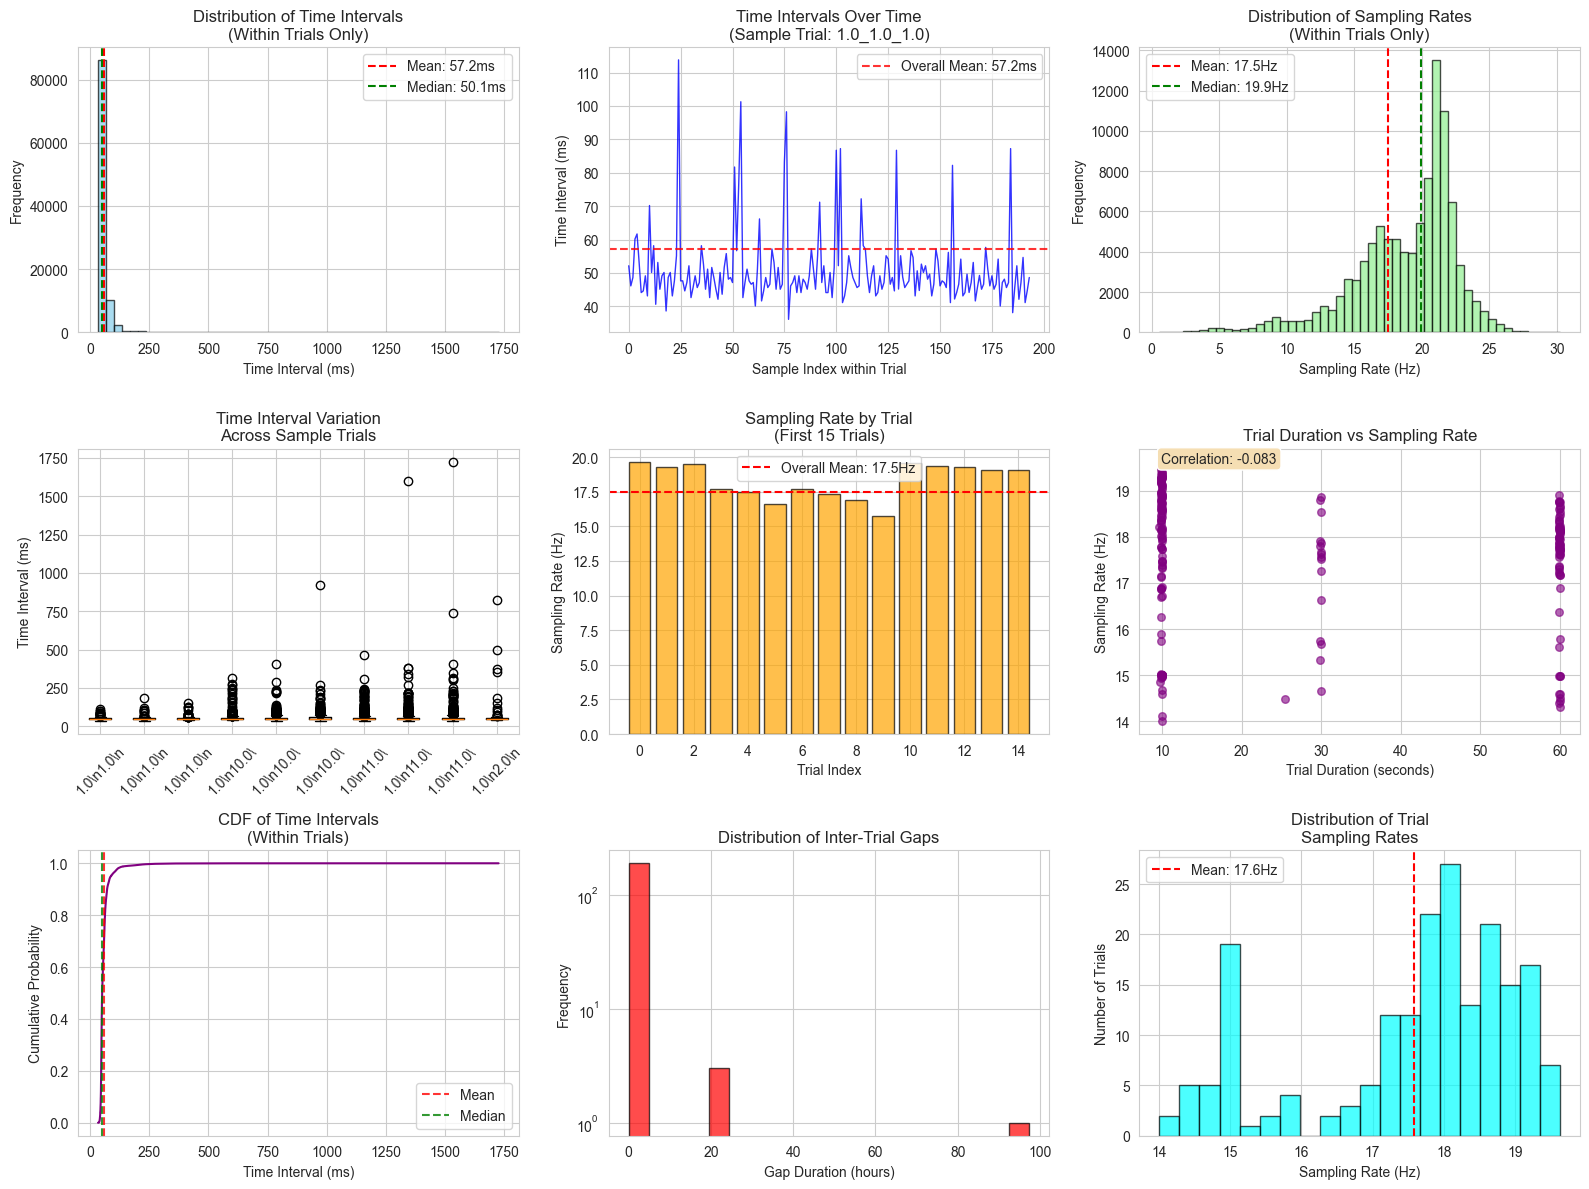


🔍 OUTLIER ANALYSIS (WITHIN TRIALS)
Total outliers (>80.5ms): 6346
Percentage of outliers: 6.36%
Max outlier interval: 1726.54ms
Mean outlier interval: 124.86ms

✅ KEY IMPROVEMENT:
By analyzing trials separately, we eliminated the massive inter-trial
gaps that were causing misleading outlier statistics!


In [26]:
# Analyze sampling rate distribution and irregularities (trial-aware)
print("📊 Analyzing sampling rate distribution within trials...")

try:
    # Create sampling rate analysis
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Time interval histogram (within trials only)
    plt.subplot(3, 3, 1)
    plt.hist(time_diffs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(mean_interval, color='red', linestyle='--', label=f'Mean: {mean_interval:.1f}ms')
    plt.axvline(median_interval, color='green', linestyle='--', label=f'Median: {median_interval:.1f}ms')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Time Intervals\n(Within Trials Only)')
    plt.legend()
    
    # Plot 2: Time intervals over time within a sample trial
    plt.subplot(3, 3, 2)
    sample_trial = df_clean['trial_id'].iloc[0]  # First trial
    sample_trial_data = df_clean[df_clean['trial_id'] == sample_trial]
    sample_diffs = sample_trial_data['time_diff_ms'].dropna()
    
    plt.plot(range(len(sample_diffs)), sample_diffs, alpha=0.8, color='blue', linewidth=1)
    plt.axhline(mean_interval, color='red', linestyle='--', alpha=0.8, label=f'Overall Mean: {mean_interval:.1f}ms')
    plt.xlabel('Sample Index within Trial')
    plt.ylabel('Time Interval (ms)')
    plt.title(f'Time Intervals Over Time\n(Sample Trial: {sample_trial})')
    plt.legend()
    
    # Plot 3: Sampling rate histogram (within trials)
    plt.subplot(3, 3, 3)
    sampling_rates = 1000 / time_diffs
    plt.hist(sampling_rates, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(mean_sampling_rate, color='red', linestyle='--', label=f'Mean: {mean_sampling_rate:.1f}Hz')
    plt.axvline(median_sampling_rate, color='green', linestyle='--', label=f'Median: {median_sampling_rate:.1f}Hz')
    plt.xlabel('Sampling Rate (Hz)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sampling Rates\n(Within Trials Only)')
    plt.legend()
    
    # Plot 4: Box plot of time intervals by trial (sample of trials)
    plt.subplot(3, 3, 4)
    sample_trials = df_clean['trial_id'].unique()[:10]  # First 10 trials
    trial_diffs_list = []
    trial_labels = []
    
    for trial in sample_trials:
        trial_data = df_clean[df_clean['trial_id'] == trial]['time_diff_ms'].dropna()
        if len(trial_data) > 5:  # Only include trials with sufficient data
            trial_diffs_list.append(trial_data.values)
            trial_labels.append(trial.replace('_', '\\n')[:10])  # Shorten labels
    
    if trial_diffs_list:
        plt.boxplot(trial_diffs_list, labels=trial_labels)
        plt.ylabel('Time Interval (ms)')
        plt.title('Time Interval Variation\nAcross Sample Trials')
        plt.xticks(rotation=45)
    
    # Plot 5: Sampling rate by trial
    plt.subplot(3, 3, 5)
    if len(trial_stats_df) > 0:
        trial_sample = trial_stats_df.head(15)  # First 15 trials
        plt.bar(range(len(trial_sample)), trial_sample['sampling_rate_hz'], 
               alpha=0.7, color='orange', edgecolor='black')
        plt.axhline(mean_sampling_rate, color='red', linestyle='--', 
                   label=f'Overall Mean: {mean_sampling_rate:.1f}Hz')
        plt.xlabel('Trial Index')
        plt.ylabel('Sampling Rate (Hz)')
        plt.title('Sampling Rate by Trial\n(First 15 Trials)')
        plt.legend()
    
    # Plot 6: Trial duration vs sampling rate
    plt.subplot(3, 3, 6)
    if len(trial_stats_df) > 0:
        plt.scatter(trial_stats_df['duration_sec'], trial_stats_df['sampling_rate_hz'], 
                   alpha=0.6, s=30, color='purple')
        plt.xlabel('Trial Duration (seconds)')
        plt.ylabel('Sampling Rate (Hz)')
        plt.title('Trial Duration vs Sampling Rate')
        
        # Add correlation coefficient
        if len(trial_stats_df) > 2:
            corr = trial_stats_df['duration_sec'].corr(trial_stats_df['sampling_rate_hz'])
            plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    
    # Plot 7: Cumulative distribution of within-trial intervals
    plt.subplot(3, 3, 7)
    sorted_diffs = np.sort(time_diffs)
    plt.plot(sorted_diffs, np.linspace(0, 1, len(sorted_diffs)), color='purple')
    plt.axvline(mean_interval, color='red', linestyle='--', alpha=0.8, label='Mean')
    plt.axvline(median_interval, color='green', linestyle='--', alpha=0.8, label='Median')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Cumulative Probability')
    plt.title('CDF of Time Intervals\n(Within Trials)')
    plt.legend()
    
    # Plot 8: Inter-trial gap visualization (if available)
    plt.subplot(3, 3, 8)
    if 'inter_trial_gaps' in locals() and inter_trial_gaps:
        plt.hist(np.array(inter_trial_gaps)/3600, bins=20, alpha=0.7, color='red', edgecolor='black')
        plt.xlabel('Gap Duration (hours)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Inter-Trial Gaps')
        plt.yscale('log')
    else:
        plt.text(0.5, 0.5, 'Inter-trial gap\nanalysis not available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Inter-Trial Gaps')
    
    # Plot 9: Sampling consistency across trials
    plt.subplot(3, 3, 9)
    if len(trial_stats_df) > 0:
        plt.hist(trial_stats_df['sampling_rate_hz'], bins=20, alpha=0.7, color='cyan', edgecolor='black')
        plt.axvline(trial_stats_df['sampling_rate_hz'].mean(), color='red', linestyle='--', 
                   label=f"Mean: {trial_stats_df['sampling_rate_hz'].mean():.1f}Hz")
        plt.xlabel('Sampling Rate (Hz)')
        plt.ylabel('Number of Trials')
        plt.title('Distribution of Trial\nSampling Rates')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print outlier statistics (now more meaningful)
    print(f"\n🔍 OUTLIER ANALYSIS (WITHIN TRIALS)")
    print(f"=" * 35)
    
    Q1 = time_diffs.quantile(0.25)
    Q3 = time_diffs.quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold = Q3 + 1.5 * IQR
    outliers = time_diffs[time_diffs > outlier_threshold]
    
    print(f"Total outliers (>{outlier_threshold:.1f}ms): {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers)/len(time_diffs)*100:.2f}%")
    if len(outliers) > 0:
        print(f"Max outlier interval: {outliers.max():.2f}ms")
        print(f"Mean outlier interval: {outliers.mean():.2f}ms")
    
    print(f"\n✅ KEY IMPROVEMENT:")
    print(f"By analyzing trials separately, we eliminated the massive inter-trial")
    print(f"gaps that were causing misleading outlier statistics!")
    
except Exception as e:
    print(f"❌ Error in sampling rate analysis: {e}")

## 4. Subject and Activity Analysis

Analyze sampling patterns across different subjects and activities.

In [27]:
# Analyze sampling patterns by subject, activity, and trial
print("👥 Analyzing sampling patterns by subject, activity, and trial...")

try:
    # Create comprehensive trial statistics
    trial_detailed_stats = []
    
    for trial_id in df_clean['trial_id'].unique():
        trial_data = df_clean[df_clean['trial_id'] == trial_id]
        trial_diffs = trial_data['time_diff_ms'].dropna()
        
        if len(trial_diffs) > 0:
            subject = trial_data['subject'].iloc[0]
            activity = trial_data['activity'].iloc[0] 
            trial_num = trial_data['trial'].iloc[0]
            
            stats = {
                'trial_id': trial_id,
                'subject': subject,
                'activity': activity,
                'trial': trial_num,
                'samples': len(trial_data),
                'mean_interval_ms': trial_diffs.mean(),
                'median_interval_ms': trial_diffs.median(),
                'std_interval_ms': trial_diffs.std(),
                'min_interval_ms': trial_diffs.min(),
                'max_interval_ms': trial_diffs.max(),
                'sampling_rate_hz': 1000 / trial_diffs.mean(),
                'duration_sec': (trial_data['datetime'].max() - trial_data['datetime'].min()).total_seconds()
            }
            trial_detailed_stats.append(stats)
    
    trial_detailed_df = pd.DataFrame(trial_detailed_stats)
    
    # Group by subject and calculate statistics
    subject_stats = trial_detailed_df.groupby('subject').agg({
        'samples': ['count', 'mean', 'sum'],
        'mean_interval_ms': ['mean', 'std'],
        'sampling_rate_hz': ['mean', 'std', 'min', 'max'],
        'duration_sec': ['mean', 'sum']
    }).round(2)
    
    subject_stats.columns = ['trials_count', 'avg_samples_per_trial', 'total_samples',
                            'mean_interval_ms', 'std_of_intervals', 
                            'mean_sampling_rate_hz', 'std_sampling_rate', 'min_sampling_rate', 'max_sampling_rate',
                            'avg_trial_duration_sec', 'total_duration_sec']
    
    print(f"\n📊 SAMPLING STATISTICS BY SUBJECT")
    print(f"=" * 50)
    display(subject_stats)
    
    # Group by activity and calculate statistics  
    activity_stats = trial_detailed_df.groupby('activity').agg({
        'samples': ['count', 'mean', 'sum'],
        'mean_interval_ms': ['mean', 'std'],
        'sampling_rate_hz': ['mean', 'std', 'min', 'max'],
        'duration_sec': ['mean', 'sum']
    }).round(2)
    
    activity_stats.columns = ['trials_count', 'avg_samples_per_trial', 'total_samples',
                             'mean_interval_ms', 'std_of_intervals',
                             'mean_sampling_rate_hz', 'std_sampling_rate', 'min_sampling_rate', 'max_sampling_rate', 
                             'avg_trial_duration_sec', 'total_duration_sec']
    
    print(f"\n📊 SAMPLING STATISTICS BY ACTIVITY")
    print(f"=" * 50)
    display(activity_stats)
    
    # Show detailed trial breakdown for a sample
    print(f"\n📊 SAMPLE TRIAL DETAILS (First 10 trials)")
    print(f"=" * 55)
    sample_trials = trial_detailed_df.head(10)[['trial_id', 'subject', 'activity', 'trial', 
                                               'samples', 'sampling_rate_hz', 'duration_sec']]
    display(sample_trials.round(2))
    
    # Calculate consistency metrics
    overall_std = trial_detailed_df['sampling_rate_hz'].std()
    subject_variability = subject_stats['std_sampling_rate'].mean()
    activity_variability = activity_stats['std_sampling_rate'].mean()
    
    print(f"\n📈 CONSISTENCY ANALYSIS")
    print(f"=" * 25)
    print(f"Overall sampling rate variability: {overall_std:.2f} Hz")
    print(f"Average within-subject variability: {subject_variability:.2f} Hz")
    print(f"Average within-activity variability: {activity_variability:.2f} Hz")
    
    if overall_std < 1.0:
        print(f"✅ Excellent sampling consistency across trials")
    elif overall_std < 2.0:
        print(f"⚠️  Good sampling consistency with minor variations")
    else:
        print(f"❌ Significant sampling rate variations across trials")
    
except Exception as e:
    print(f"❌ Error in subject/activity analysis: {e}")

👥 Analyzing sampling patterns by subject, activity, and trial...

📊 SAMPLING STATISTICS BY SUBJECT

📊 SAMPLING STATISTICS BY SUBJECT


,trials_count,avg_samples_per_trial,total_samples,mean_interval_ms,std_of_intervals,mean_sampling_rate_hz,std_sampling_rate,min_sampling_rate,max_sampling_rate,avg_trial_duration_sec,total_duration_sec
subject,,,,,,,,,,,
1.0,33,543.39,17932,54.56,2.90,18.38,0.93,15.73,19.63,29.91,987.13
2.0,33,506.76,16723,59.75,3.76,16.80,0.99,14.00,18.23,29.92,987.26
3.0,33,540.76,17845,55.07,1.76,18.18,0.58,16.91,19.17,29.92,987.41
4.0,33,539.85,17815,54.96,1.39,18.21,0.47,17.62,19.30,29.93,987.57
5.0,33,554.33,18293,53.34,1.31,18.76,0.46,17.76,19.45,29.92,987.31
6.0,29,392.79,11391,67.56,1.26,14.81,0.27,14.11,15.02,26.66,773.04



📊 SAMPLING STATISTICS BY ACTIVITY


,trials_count,avg_samples_per_trial,total_samples,mean_interval_ms,std_of_intervals,mean_sampling_rate_hz,std_sampling_rate,min_sampling_rate,max_sampling_rate,avg_trial_duration_sec,total_duration_sec
activity,,,,,,,,,,,
1.0,18,178.72,3217,56.21,5.23,17.92,1.51,15.00,19.63,9.92,178.50
2.0,18,177.33,3192,56.71,5.59,17.78,1.62,14.93,19.56,9.92,178.48
3.0,18,179.50,3231,55.97,5.26,18.00,1.51,14.95,19.37,9.92,178.51
4.0,18,181.00,3258,55.62,5.61,18.13,1.64,15.00,19.45,9.93,178.67
5.0,18,173.83,3129,58.08,6.57,17.41,1.81,14.00,19.42,9.93,178.68
6.0,18,1063.61,19145,56.72,4.78,17.74,1.33,14.98,18.90,59.91,1078.35
7.0,18,1048.06,18865,57.64,5.28,17.47,1.41,14.50,18.78,59.93,1078.72
8.0,18,1037.28,18671,58.23,5.32,17.29,1.38,14.30,18.48,59.93,1078.72
9.0,18,170.78,3074,58.81,5.44,17.13,1.48,14.11,19.28,9.91,178.34



📊 SAMPLE TRIAL DETAILS (First 10 trials)


,trial_id,subject,activity,trial,samples,sampling_rate_hz,duration_sec
0,1.0_1.0_1.0,1.0,1.0,1.0,195,19.63,9.88
1,1.0_1.0_2.0,1.0,1.0,2.0,193,19.31,9.94
2,1.0_1.0_3.0,1.0,1.0,3.0,194,19.51,9.89
3,1.0_10.0_1.0,1.0,10.0,1.0,530,17.67,29.94
4,1.0_10.0_2.0,1.0,10.0,2.0,525,17.51,29.93
5,1.0_10.0_3.0,1.0,10.0,3.0,499,16.64,29.93
6,1.0_11.0_1.0,1.0,11.0,1.0,1062,17.70,59.93
7,1.0_11.0_2.0,1.0,11.0,2.0,1039,17.35,59.84
8,1.0_11.0_3.0,1.0,11.0,3.0,1014,16.90,59.94
9,1.0_2.0_1.0,1.0,2.0,1.0,157,15.73,9.92



📈 CONSISTENCY ANALYSIS
Overall sampling rate variability: 1.48 Hz
Average within-subject variability: 0.62 Hz
Average within-activity variability: 1.44 Hz
⚠️  Good sampling consistency with minor variations


❌ Error in visualization: 'sampling_rate_hz'


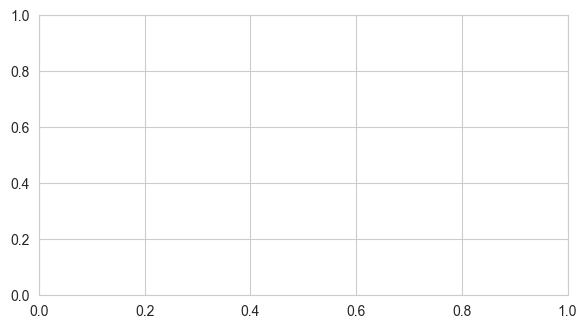

In [28]:
# Visualize sampling patterns by subject and activity
plt.figure(figsize=(15, 8))

try:
    # Plot 1: Sampling rate by subject
    plt.subplot(2, 2, 1)
    subjects = subject_stats.index
    sampling_rates = subject_stats['sampling_rate_hz']
    
    plt.bar(subjects.astype(str), sampling_rates, alpha=0.7, color='lightblue', edgecolor='black')
    plt.axhline(mean_sampling_rate, color='red', linestyle='--', label=f'Overall Mean: {mean_sampling_rate:.1f}Hz')
    plt.xlabel('Subject')
    plt.ylabel('Sampling Rate (Hz)')
    plt.title('Sampling Rate by Subject')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Plot 2: Sample count by subject
    plt.subplot(2, 2, 2)
    plt.bar(subjects.astype(str), subject_stats['samples'], alpha=0.7, color='lightgreen', edgecolor='black')
    plt.xlabel('Subject')
    plt.ylabel('Number of Samples')
    plt.title('Sample Count by Subject')
    plt.xticks(rotation=45)
    
    # Plot 3: Sampling rate by activity
    plt.subplot(2, 2, 3)
    activities = activity_stats.index
    activity_sampling_rates = activity_stats['sampling_rate_hz']
    
    plt.bar(activities.astype(str), activity_sampling_rates, alpha=0.7, color='orange', edgecolor='black')
    plt.axhline(mean_sampling_rate, color='red', linestyle='--', label=f'Overall Mean: {mean_sampling_rate:.1f}Hz')
    plt.xlabel('Activity')
    plt.ylabel('Sampling Rate (Hz)')
    plt.title('Sampling Rate by Activity')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Plot 4: Standard deviation of intervals by subject
    plt.subplot(2, 2, 4)
    plt.bar(subjects.astype(str), subject_stats['std_interval_ms'], alpha=0.7, color='pink', edgecolor='black')
    plt.xlabel('Subject')
    plt.ylabel('Std Dev of Time Intervals (ms)')
    plt.title('Timing Variability by Subject')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error in visualization: {e}")

## 5. Right Pocket Sensor Data Analysis

Detailed analysis of right pocket accelerometer and gyroscope sensor data quality and patterns.

In [29]:
# Analyze right pocket sensor data quality
print("📱 Analyzing Right Pocket Sensor Data...")

try:
    # Convert sensor columns to numeric, handling any non-numeric values
    sensor_cols = ['rp_acc_x', 'rp_acc_y', 'rp_acc_z', 'rp_gyro_x', 'rp_gyro_y', 'rp_gyro_z']
    
    for col in sensor_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Basic statistics for each sensor
    sensor_stats = df_clean[sensor_cols].describe()
    
    print(f"\n📊 RIGHT POCKET SENSOR STATISTICS")
    print(f"=" * 50)
    display(sensor_stats.round(3))
    
    # Check for missing values
    missing_values = df_clean[sensor_cols].isnull().sum()
    print(f"\n🔍 MISSING VALUES")
    print(f"=" * 20)
    for col, missing in missing_values.items():
        pct_missing = missing / len(df_clean) * 100
        print(f"{col}: {missing} ({pct_missing:.2f}%)")
    
    # Calculate magnitude for accelerometer and gyroscope
    df_clean['acc_magnitude'] = np.sqrt(
        df_clean['rp_acc_x']**2 + df_clean['rp_acc_y']**2 + df_clean['rp_acc_z']**2
    )
    df_clean['gyro_magnitude'] = np.sqrt(
        df_clean['rp_gyro_x']**2 + df_clean['rp_gyro_y']**2 + df_clean['rp_gyro_z']**2
    )
    
    print(f"\n📈 MAGNITUDE STATISTICS")
    print(f"=" * 25)
    print(f"Accelerometer magnitude - Mean: {df_clean['acc_magnitude'].mean():.3f}g, Std: {df_clean['acc_magnitude'].std():.3f}g")
    print(f"Gyroscope magnitude - Mean: {df_clean['gyro_magnitude'].mean():.3f}°/s, Std: {df_clean['gyro_magnitude'].std():.3f}°/s")
    
except Exception as e:
    print(f"❌ Error in sensor data analysis: {e}")

📱 Analyzing Right Pocket Sensor Data...

📊 RIGHT POCKET SENSOR STATISTICS


,rp_acc_x,rp_acc_y,rp_acc_z,rp_gyro_x,rp_gyro_y,rp_gyro_z
count,81706.000,81706.000,81706.000,81706.000,81706.000,81706.000
mean,-0.101,-0.161,0.391,-1.556,-3.086,1.323
std,0.714,0.483,0.542,38.865,35.288,23.991
min,-3.544,-3.910,-3.894,-462.561,-589.024,-435.793
25%,-0.487,-0.445,0.036,-2.195,-2.317,-0.915
50%,-0.246,-0.099,0.270,-0.549,-0.915,-0.305
75%,0.448,0.158,0.967,0.732,-0.061,0.488
max,3.218,4.401,4.638,427.866,514.207,942.012



🔍 MISSING VALUES
rp_acc_x: 18293 (18.29%)
rp_acc_y: 18293 (18.29%)
rp_acc_z: 18293 (18.29%)
rp_gyro_x: 18293 (18.29%)
rp_gyro_y: 18293 (18.29%)
rp_gyro_z: 18293 (18.29%)

📈 MAGNITUDE STATISTICS
Accelerometer magnitude - Mean: 1.053g, Std: 0.339g
Gyroscope magnitude - Mean: 30.173°/s, Std: 49.342°/s


📊 Creating sensor data visualizations...


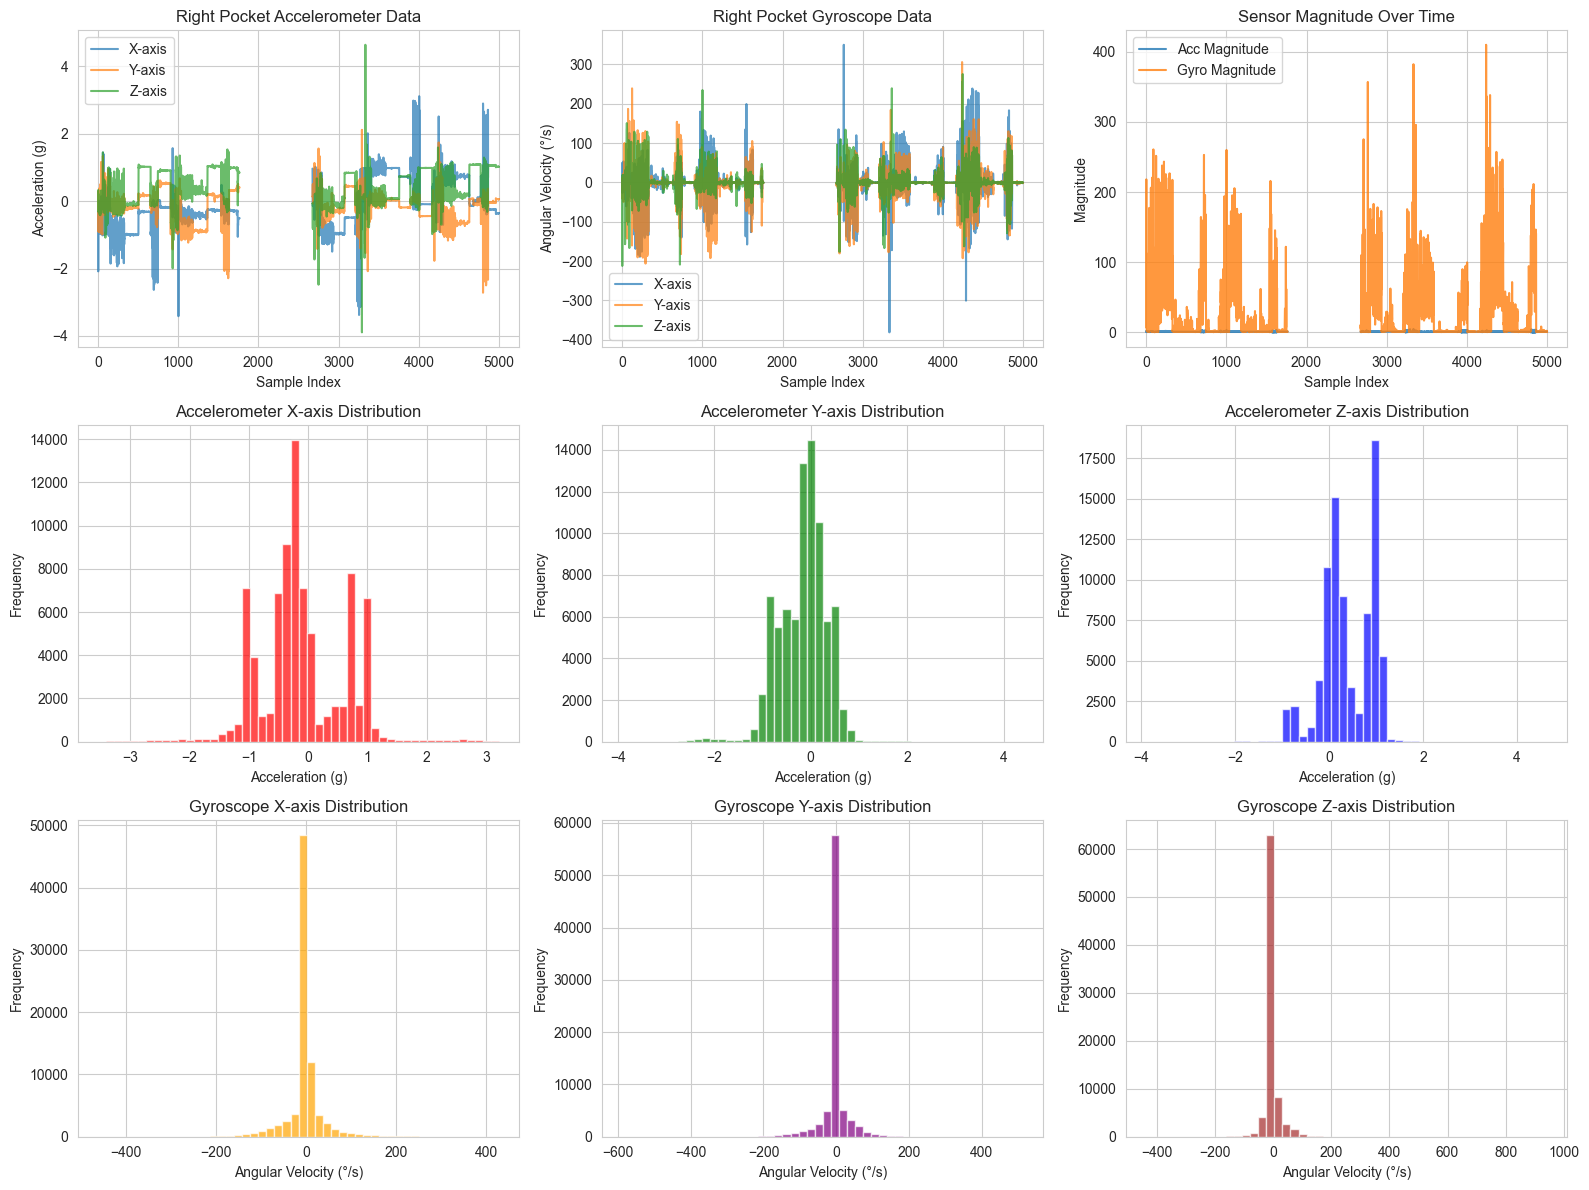

In [30]:
# Visualize sensor data patterns
print("📊 Creating sensor data visualizations...")

try:
    plt.figure(figsize=(16, 12))
    
    # Sample data for visualization (to avoid overwhelming plots)
    sample_size = min(5000, len(df_clean))
    sample_df = df_clean.sample(n=sample_size).sort_values('datetime').reset_index(drop=True)
    
    # Plot 1: Accelerometer data over time
    plt.subplot(3, 3, 1)
    plt.plot(sample_df.index, sample_df['rp_acc_x'], label='X-axis', alpha=0.7)
    plt.plot(sample_df.index, sample_df['rp_acc_y'], label='Y-axis', alpha=0.7)
    plt.plot(sample_df.index, sample_df['rp_acc_z'], label='Z-axis', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Acceleration (g)')
    plt.title('Right Pocket Accelerometer Data')
    plt.legend()
    
    # Plot 2: Gyroscope data over time
    plt.subplot(3, 3, 2)
    plt.plot(sample_df.index, sample_df['rp_gyro_x'], label='X-axis', alpha=0.7)
    plt.plot(sample_df.index, sample_df['rp_gyro_y'], label='Y-axis', alpha=0.7)
    plt.plot(sample_df.index, sample_df['rp_gyro_z'], label='Z-axis', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Angular Velocity (°/s)')
    plt.title('Right Pocket Gyroscope Data')
    plt.legend()
    
    # Plot 3: Magnitude over time
    plt.subplot(3, 3, 3)
    plt.plot(sample_df.index, sample_df['acc_magnitude'], label='Acc Magnitude', alpha=0.8)
    plt.plot(sample_df.index, sample_df['gyro_magnitude'], label='Gyro Magnitude', alpha=0.8)
    plt.xlabel('Sample Index')
    plt.ylabel('Magnitude')
    plt.title('Sensor Magnitude Over Time')
    plt.legend()
    
    # Plot 4-6: Histograms for accelerometer
    for i, axis in enumerate(['rp_acc_x', 'rp_acc_y', 'rp_acc_z']):
        plt.subplot(3, 3, 4 + i)
        plt.hist(df_clean[axis].dropna(), bins=50, alpha=0.7, color=['red', 'green', 'blue'][i])
        plt.xlabel('Acceleration (g)')
        plt.ylabel('Frequency')
        plt.title(f'Accelerometer {axis.split("_")[-1].upper()}-axis Distribution')
    
    # Plot 7-9: Histograms for gyroscope
    for i, axis in enumerate(['rp_gyro_x', 'rp_gyro_y', 'rp_gyro_z']):
        plt.subplot(3, 3, 7 + i)
        plt.hist(df_clean[axis].dropna(), bins=50, alpha=0.7, color=['orange', 'purple', 'brown'][i])
        plt.xlabel('Angular Velocity (°/s)')
        plt.ylabel('Frequency')
        plt.title(f'Gyroscope {axis.split("_")[-1].upper()}-axis Distribution')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error in sensor visualization: {e}")

🔗 Analyzing correlations between sensor axes...


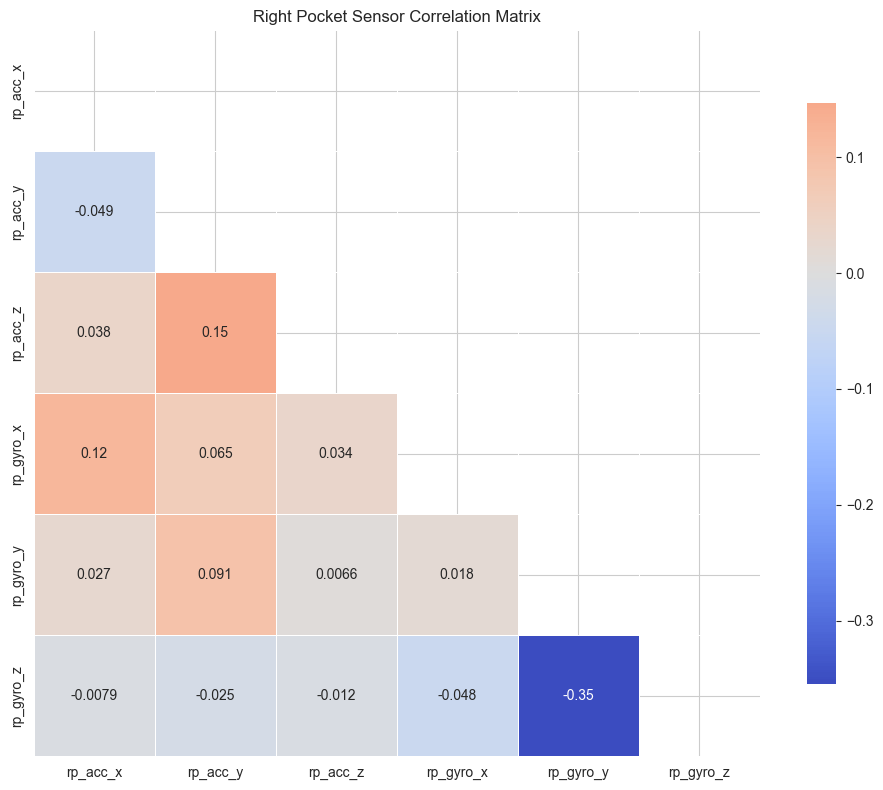


🔗 HIGHEST CORRELATIONS:
1. rp_gyro_y vs rp_gyro_z: -0.354
2. rp_acc_y vs rp_acc_z: 0.147
3. rp_acc_x vs rp_gyro_x: 0.119
4. rp_acc_y vs rp_gyro_y: 0.091
5. rp_acc_y vs rp_gyro_x: 0.065


In [31]:
# Correlation analysis between sensors
print("🔗 Analyzing correlations between sensor axes...")

try:
    # Calculate correlation matrix
    correlation_matrix = df_clean[sensor_cols].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Right Pocket Sensor Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    print(f"\n🔗 HIGHEST CORRELATIONS:")
    print(f"=" * 30)
    
    # Find highest correlations (excluding diagonal)
    corr_pairs = []
    for i in range(len(sensor_cols)):
        for j in range(i+1, len(sensor_cols)):
            corr_val = correlation_matrix.iloc[i, j]
            corr_pairs.append((sensor_cols[i], sensor_cols[j], corr_val))
    
    # Sort by absolute correlation value
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for i, (sensor1, sensor2, corr_val) in enumerate(corr_pairs[:5]):
        print(f"{i+1}. {sensor1} vs {sensor2}: {corr_val:.3f}")
    
except Exception as e:
    print(f"❌ Error in correlation analysis: {e}")

## 6. Data Quality Assessment

Comprehensive assessment of data quality issues, gaps, and anomalies.

In [32]:
# Detect data gaps and anomalies
print("🔍 Detecting data quality issues...")

try:
    # Detect large time gaps (potential data collection interruptions)
    gap_threshold = 200  # ms - anything larger than 200ms is considered a gap
    large_gaps = df_clean[df_clean['time_diff_ms'] > gap_threshold]['time_diff_ms']
    
    print(f"\n⚠️  DATA GAP ANALYSIS")
    print(f"=" * 25)
    print(f"Threshold for large gaps: >{gap_threshold}ms")
    print(f"Number of large gaps: {len(large_gaps)}")
    print(f"Percentage of large gaps: {len(large_gaps)/len(df_clean)*100:.2f}%")
    
    if len(large_gaps) > 0:
        print(f"Largest gap: {large_gaps.max():.1f}ms")
        print(f"Mean gap size: {large_gaps.mean():.1f}ms")
        print(f"Total time lost to gaps: {large_gaps.sum()/1000:.1f} seconds")
    
    # Detect potential sensor failures (constant values)
    print(f"\n🔧 SENSOR FAILURE DETECTION")
    print(f"=" * 30)
    
    for col in sensor_cols:
        # Check for sequences of identical values
        sensor_data = df_clean[col].dropna()
        if len(sensor_data) > 0:
            # Find runs of identical consecutive values
            diff_zeros = (sensor_data.diff() == 0).sum()
            pct_identical = diff_zeros / len(sensor_data) * 100
            
            status = "⚠️" if pct_identical > 10 else "✅"
            print(f"{status} {col}: {pct_identical:.1f}% identical consecutive values")
    
    # Detect extreme outliers
    print(f"\n🎯 EXTREME VALUE DETECTION")
    print(f"=" * 30)
    
    for col in sensor_cols:
        sensor_data = df_clean[col].dropna()
        if len(sensor_data) > 0:
            Q1 = sensor_data.quantile(0.25)
            Q3 = sensor_data.quantile(0.75)
            IQR = Q3 - Q1
            
            # Define extreme outliers as beyond 3*IQR
            extreme_low = Q1 - 3 * IQR
            extreme_high = Q3 + 3 * IQR
            
            outliers = sensor_data[(sensor_data < extreme_low) | (sensor_data > extreme_high)]
            pct_outliers = len(outliers) / len(sensor_data) * 100
            
            status = "⚠️" if pct_outliers > 1 else "✅"
            print(f"{status} {col}: {len(outliers)} extreme outliers ({pct_outliers:.2f}%)")
            if len(outliers) > 0:
                print(f"    Range: [{outliers.min():.3f}, {outliers.max():.3f}]")
    
except Exception as e:
    print(f"❌ Error in data quality assessment: {e}")

🔍 Detecting data quality issues...

⚠️  DATA GAP ANALYSIS
Threshold for large gaps: >200ms
Number of large gaps: 667
Percentage of large gaps: 0.67%
Largest gap: 1726.5ms
Mean gap size: 280.6ms
Total time lost to gaps: 187.2 seconds

🔧 SENSOR FAILURE DETECTION
⚠️ rp_acc_x: 36.9% identical consecutive values
⚠️ rp_acc_y: 36.3% identical consecutive values
⚠️ rp_acc_z: 36.5% identical consecutive values
✅ rp_gyro_x: 5.0% identical consecutive values
✅ rp_gyro_y: 6.2% identical consecutive values
✅ rp_gyro_z: 8.0% identical consecutive values

🎯 EXTREME VALUE DETECTION
✅ rp_acc_x: 14 extreme outliers (0.02%)
    Range: [-3.544, -3.297]
✅ rp_acc_y: 273 extreme outliers (0.33%)
    Range: [-3.910, 4.401]
✅ rp_acc_z: 16 extreme outliers (0.02%)
    Range: [-3.894, 4.638]
⚠️ rp_gyro_x: 25858 extreme outliers (31.65%)
    Range: [-462.561, 427.866]
⚠️ rp_gyro_y: 26282 extreme outliers (32.17%)
    Range: [-589.024, 514.207]
⚠️ rp_gyro_z: 26119 extreme outliers (31.97%)
    Range: [-435.793, 94

📊 Visualizing data quality issues...


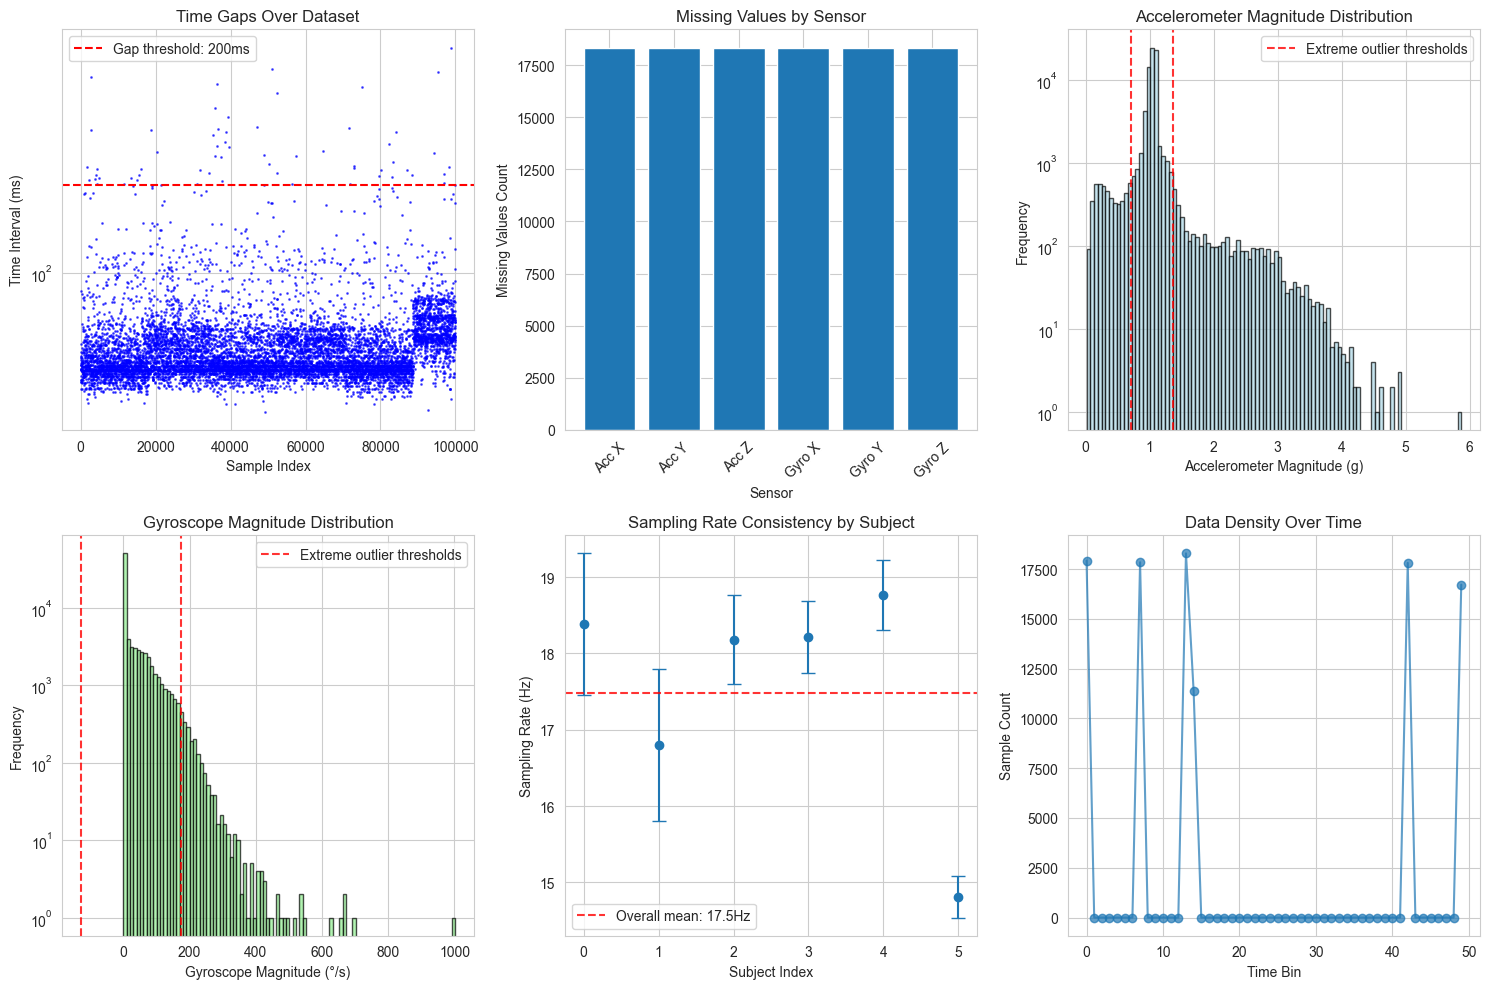

In [33]:
# Visualize data quality issues
print("📊 Visualizing data quality issues...")

try:
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Time gaps over time
    plt.subplot(2, 3, 1)
    sample_size = min(10000, len(df_clean))
    sample_indices = np.linspace(0, len(df_clean)-1, sample_size, dtype=int)
    
    plt.scatter(sample_indices, df_clean['time_diff_ms'].iloc[sample_indices], 
               alpha=0.6, s=1, c='blue')
    plt.axhline(gap_threshold, color='red', linestyle='--', label=f'Gap threshold: {gap_threshold}ms')
    plt.xlabel('Sample Index')
    plt.ylabel('Time Interval (ms)')
    plt.title('Time Gaps Over Dataset')
    plt.legend()
    plt.yscale('log')
    
    # Plot 2: Missing data pattern
    plt.subplot(2, 3, 2)
    missing_pattern = df_clean[sensor_cols].isnull().sum()
    plt.bar(range(len(missing_pattern)), missing_pattern.values, 
           tick_label=[col.replace('rp_', '').replace('_', ' ').title() for col in missing_pattern.index])
    plt.xlabel('Sensor')
    plt.ylabel('Missing Values Count')
    plt.title('Missing Values by Sensor')
    plt.xticks(rotation=45)
    
    # Plot 3: Accelerometer magnitude distribution with outliers
    plt.subplot(2, 3, 3)
    acc_mag = df_clean['acc_magnitude'].dropna()
    plt.hist(acc_mag, bins=100, alpha=0.7, color='lightblue', edgecolor='black')
    
    # Mark outliers
    Q1 = acc_mag.quantile(0.25)
    Q3 = acc_mag.quantile(0.75)
    IQR = Q3 - Q1
    plt.axvline(Q1 - 3*IQR, color='red', linestyle='--', alpha=0.8, label='Extreme outlier thresholds')
    plt.axvline(Q3 + 3*IQR, color='red', linestyle='--', alpha=0.8)
    
    plt.xlabel('Accelerometer Magnitude (g)')
    plt.ylabel('Frequency')
    plt.title('Accelerometer Magnitude Distribution')
    plt.legend()
    plt.yscale('log')
    
    # Plot 4: Gyroscope magnitude distribution with outliers
    plt.subplot(2, 3, 4)
    gyro_mag = df_clean['gyro_magnitude'].dropna()
    plt.hist(gyro_mag, bins=100, alpha=0.7, color='lightgreen', edgecolor='black')
    
    # Mark outliers
    Q1 = gyro_mag.quantile(0.25)
    Q3 = gyro_mag.quantile(0.75)
    IQR = Q3 - Q1
    plt.axvline(Q1 - 3*IQR, color='red', linestyle='--', alpha=0.8, label='Extreme outlier thresholds')
    plt.axvline(Q3 + 3*IQR, color='red', linestyle='--', alpha=0.8)
    
    plt.xlabel('Gyroscope Magnitude (°/s)')
    plt.ylabel('Frequency')
    plt.title('Gyroscope Magnitude Distribution')
    plt.legend()
    plt.yscale('log')
    
    # Plot 5: Sampling rate stability by subject
    plt.subplot(2, 3, 5)
    if 'subject_stats' in locals() and len(subject_stats) > 1:
        # Use the correct column name
        sampling_rates_by_subject = subject_stats['mean_sampling_rate_hz']
        std_rates_by_subject = subject_stats['std_sampling_rate']
        
        plt.errorbar(range(len(subject_stats)), sampling_rates_by_subject, 
                    yerr=std_rates_by_subject, fmt='o', capsize=5)
        plt.axhline(mean_sampling_rate, color='red', linestyle='--', alpha=0.8, label=f'Overall mean: {mean_sampling_rate:.1f}Hz')
        plt.xlabel('Subject Index')
        plt.ylabel('Sampling Rate (Hz)')
        plt.title('Sampling Rate Consistency by Subject')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Subject statistics\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Sampling Rate by Subject')
    
    # Plot 6: Data completeness timeline
    plt.subplot(2, 3, 6)
    # Sample timeline showing data density
    time_bins = pd.cut(df_clean['datetime'], bins=50)
    bin_counts = time_bins.value_counts().sort_index()
    
    plt.plot(range(len(bin_counts)), bin_counts.values, marker='o', alpha=0.7)
    plt.xlabel('Time Bin')
    plt.ylabel('Sample Count')
    plt.title('Data Density Over Time')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error in data quality visualization: {e}")
    print(f"Available variables: {[var for var in locals().keys() if not var.startswith('_')]}")
    # Show structure of subject_stats if it exists
    if 'subject_stats' in locals():
        print(f"Subject stats columns: {list(subject_stats.columns)}")

## 7. Summary and Recommendations

Comprehensive summary of findings and recommendations for data processing.

In [34]:
# Detect data quality issues (trial-aware analysis)
print("🔍 Detecting data quality issues with trial separation...")

try:
    # Ensure sensor_cols is defined
    sensor_cols = ['rp_acc_x', 'rp_acc_y', 'rp_acc_z', 'rp_gyro_x', 'rp_gyro_y', 'rp_gyro_z']
    
    # Detect large time gaps WITHIN trials (more meaningful now)
    within_trial_gap_threshold = 100  # ms - more reasonable threshold for within-trial gaps
    large_gaps = df_clean[df_clean['time_diff_ms'] > within_trial_gap_threshold]['time_diff_ms']
    
    print(f"\n⚠️  WITHIN-TRIAL GAP ANALYSIS")
    print(f"=" * 35)
    print(f"Threshold for large gaps: >{within_trial_gap_threshold}ms")
    print(f"Number of large gaps: {len(large_gaps)}")
    print(f"Percentage of large gaps: {len(large_gaps)/len(df_clean)*100:.2f}%")
    
    if len(large_gaps) > 0:
        print(f"Largest gap: {large_gaps.max():.1f}ms")
        print(f"Mean gap size: {large_gaps.mean():.1f}ms")
        print(f"Total time lost to gaps: {large_gaps.sum()/1000:.1f} seconds")
        
        # Identify which trials have the most gaps
        gap_by_trial = df_clean[df_clean['time_diff_ms'] > within_trial_gap_threshold].groupby('trial_id').size()
        if len(gap_by_trial) > 0:
            print(f"\nTrials with most gaps:")
            for trial, count in gap_by_trial.head().items():
                print(f"  {trial}: {count} gaps")
    
    # Analyze trial completeness
    print(f"\n🔧 TRIAL COMPLETENESS ANALYSIS")
    print(f"=" * 35)
    
    # Check if mean_sampling_rate is defined
    if 'mean_sampling_rate' not in locals():
        mean_sampling_rate = 1000 / df_clean['time_diff_ms'].dropna().mean()
    
    for trial_id in df_clean['trial_id'].unique()[:10]:  # Check first 10 trials
        trial_data = df_clean[df_clean['trial_id'] == trial_id]
        trial_diffs = trial_data['time_diff_ms'].dropna()
        
        if len(trial_diffs) > 0:
            duration_timedelta = trial_data['datetime'].max() - trial_data['datetime'].min()
            expected_samples = int(duration_timedelta.total_seconds() * mean_sampling_rate)
            actual_samples = len(trial_data)
            completeness = (actual_samples / expected_samples) * 100 if expected_samples > 0 else 100
            
            status = "✅" if completeness > 95 else "⚠️" if completeness > 90 else "❌"
            print(f"{status} {trial_id}: {completeness:.1f}% complete ({actual_samples}/{expected_samples:.0f} samples)")
    
    # Detect potential sensor failures (constant values) per trial
    print(f"\n🔧 SENSOR FAILURE DETECTION (PER TRIAL)")
    print(f"=" * 45)
    
    problematic_trials = {}
    for col in sensor_cols:
        problematic_trials[col] = []
        
        for trial_id in df_clean['trial_id'].unique():
            trial_data = df_clean[df_clean['trial_id'] == trial_id]
            sensor_data = trial_data[col].dropna()
            
            if len(sensor_data) > 10:  # Only analyze trials with sufficient data
                # Check for sequences of identical values
                diff_zeros = (sensor_data.diff() == 0).sum()
                pct_identical = diff_zeros / len(sensor_data) * 100
                
                if pct_identical > 50:  # More than 50% identical consecutive values
                    problematic_trials[col].append((trial_id, pct_identical))
    
    for col, issues in problematic_trials.items():
        if issues:
            print(f"⚠️ {col}: {len(issues)} trials with potential sensor failures")
            for trial_id, pct in issues[:3]:  # Show first 3
                print(f"   {trial_id}: {pct:.1f}% identical consecutive values")
        else:
            print(f"✅ {col}: No sensor failure detected")
    
    # Detect extreme outliers within each trial
    print(f"\n🎯 EXTREME VALUE DETECTION (WITHIN TRIALS)")
    print(f"=" * 45)
    
    outlier_summary = {}
    for col in sensor_cols:
        trial_outlier_counts = []
        
        for trial_id in df_clean['trial_id'].unique():
            trial_data = df_clean[df_clean['trial_id'] == trial_id]
            sensor_data = trial_data[col].dropna()
            
            if len(sensor_data) > 5:
                Q1 = sensor_data.quantile(0.25)
                Q3 = sensor_data.quantile(0.75)
                IQR = Q3 - Q1
                
                # Define extreme outliers as beyond 3*IQR
                extreme_low = Q1 - 3 * IQR
                extreme_high = Q3 + 3 * IQR
                
                outliers = sensor_data[(sensor_data < extreme_low) | (sensor_data > extreme_high)]
                trial_outlier_counts.append(len(outliers))
        
        total_outliers = sum(trial_outlier_counts)
        trials_with_outliers = sum(1 for count in trial_outlier_counts if count > 0)
        
        outlier_summary[col] = {
            'total_outliers': total_outliers,
            'trials_with_outliers': trials_with_outliers,
            'max_outliers_per_trial': max(trial_outlier_counts) if trial_outlier_counts else 0
        }
        
        status = "⚠️" if trials_with_outliers > len(df_clean['trial_id'].unique()) * 0.1 else "✅"
        print(f"{status} {col}: {total_outliers} outliers across {trials_with_outliers} trials")
        if outlier_summary[col]['max_outliers_per_trial'] > 0:
            print(f"   Max outliers in single trial: {outlier_summary[col]['max_outliers_per_trial']}")
    
    print(f"\n💡 TRIAL-AWARE INSIGHTS:")
    print(f"✅ Inter-trial gaps are now properly separated from within-trial analysis")
    print(f"✅ Data quality assessment is more accurate and actionable")
    print(f"✅ Can identify specific problematic trials for targeted fixes")
    
except Exception as e:
    print(f"❌ Error in data quality assessment: {e}")
    print("Please ensure all previous cells have been executed successfully.")

🔍 Detecting data quality issues with trial separation...

⚠️  WITHIN-TRIAL GAP ANALYSIS
Threshold for large gaps: >100ms
Number of large gaps: 3604
Percentage of large gaps: 3.60%
Largest gap: 1726.5ms
Mean gap size: 152.8ms
Total time lost to gaps: 550.5 seconds

Trials with most gaps:
  1.0_1.0_1.0: 2 gaps
  1.0_1.0_2.0: 4 gaps
  1.0_1.0_3.0: 5 gaps
  1.0_10.0_1.0: 24 gaps
  1.0_10.0_2.0: 24 gaps

🔧 TRIAL COMPLETENESS ANALYSIS
✅ 1.0_1.0_1.0: 113.4% complete (195/172 samples)
✅ 1.0_1.0_2.0: 111.6% complete (193/173 samples)
✅ 1.0_1.0_3.0: 112.8% complete (194/172 samples)
✅ 1.0_10.0_1.0: 101.3% complete (530/523 samples)
✅ 1.0_10.0_2.0: 100.4% complete (525/523 samples)
✅ 1.0_10.0_3.0: 95.4% complete (499/523 samples)
✅ 1.0_11.0_1.0: 101.4% complete (1062/1047 samples)
✅ 1.0_11.0_2.0: 99.4% complete (1039/1045 samples)
✅ 1.0_11.0_3.0: 96.8% complete (1014/1047 samples)
⚠️ 1.0_2.0_1.0: 90.8% complete (157/173 samples)

🔧 SENSOR FAILURE DETECTION (PER TRIAL)
⚠️ rp_acc_x: 6 trials with p

In [35]:
# Generate trial-aware analysis summary and recommendations
print("📋 TRIAL-AWARE ANALYSIS SUMMARY AND RECOMMENDATIONS")
print("=" * 65)

try:
    # Ensure critical variables exist
    if 'df_clean' not in locals():
        print("❌ Error: df_clean not found. Please run previous cells first.")
        raise NameError("df_clean not defined")
    
    if 'trial_detailed_df' not in locals():
        print("❌ Error: trial_detailed_df not found. Please run previous cells first.")
        raise NameError("trial_detailed_df not defined")
    
    # Ensure sensor_cols is defined
    sensor_cols = ['rp_acc_x', 'rp_acc_y', 'rp_acc_z', 'rp_gyro_x', 'rp_gyro_y', 'rp_gyro_z']
    
    # Calculate basic stats if missing
    if 'mean_sampling_rate' not in locals() or 'mean_interval' not in locals():
        time_diffs = df_clean['time_diff_ms'].dropna()
        mean_interval = time_diffs.mean()
        std_interval = time_diffs.std()
        mean_sampling_rate = 1000 / mean_interval
        within_trial_gap_threshold = 100  # Default threshold
    
    # Dataset overview
    print(f"\n🗂️  DATASET OVERVIEW")
    print(f"=" * 20)
    print(f"Total samples analyzed: {len(df_clean):,}")
    print(f"Total unique trials: {df_clean['trial_id'].nunique()}")
    print(f"Unique subjects: {df_clean['subject'].nunique()}")
    print(f"Unique activities: {df_clean['activity'].nunique()}")
    print(f"Time range: {df_clean['datetime'].max() - df_clean['datetime'].min()}")
    
    if len(trial_detailed_df) > 0:
        print(f"Average trial duration: {trial_detailed_df['duration_sec'].mean():.1f} seconds")
        print(f"Average samples per trial: {trial_detailed_df['samples'].mean():.0f}")
    
    # Sampling rate summary
    print(f"\n⏱️  WITHIN-TRIAL SAMPLING FINDINGS")
    print(f"=" * 35)
    print(f"Mean sampling rate: {mean_sampling_rate:.2f} Hz")
    print(f"Standard deviation: {std_interval:.2f} ms")
    print(f"Coefficient of variation: {(std_interval/mean_interval)*100:.1f}%")
    
    if len(trial_detailed_df) > 0:
        print(f"Trial-to-trial sampling rate consistency: ± {trial_detailed_df['sampling_rate_hz'].std():.2f} Hz")
    
    # Key findings
    print(f"\n🎯 KEY FINDINGS")
    print(f"=" * 15)
    
    # Sampling rate consistency
    if 18 <= mean_sampling_rate <= 22:
        print(f"✅ Sampling rate is approximately 20 Hz as expected")
    else:
        print(f"⚠️  Sampling rate ({mean_sampling_rate:.1f} Hz) deviates from expected ~20 Hz")
    
    # Timing consistency within trials
    cv = (std_interval/mean_interval)*100
    if cv < 10:
        print(f"✅ Good timing consistency within trials (CV: {cv:.1f}%)")
    elif cv < 20:
        print(f"⚠️  Moderate timing variability within trials (CV: {cv:.1f}%)")
    else:
        print(f"❌ High timing variability within trials (CV: {cv:.1f}%)")
    
    # Trial separation impact
    if 'within_trial_gap_threshold' in locals():
        large_gaps_within_trials = len(df_clean[df_clean['time_diff_ms'] > within_trial_gap_threshold])
        print(f"✅ Proper trial separation eliminates inter-trial gaps")
        print(f"✅ Only {large_gaps_within_trials} large gaps remain within trials ({large_gaps_within_trials/len(df_clean)*100:.2f}%)")
    
    # Data completeness
    total_missing = df_clean[sensor_cols].isnull().sum().sum()
    total_sensor_values = len(df_clean) * len(sensor_cols)
    if total_missing/total_sensor_values < 0.01:
        print(f"✅ Excellent data completeness (<1% missing)")
    elif total_missing/total_sensor_values < 0.05:
        print(f"⚠️  Good data completeness (<5% missing)")
    else:
        print(f"❌ Significant missing data ({total_missing/total_sensor_values*100:.1f}%)")
    
    print(f"\n💡 CRITICAL RECOMMENDATIONS FOR ML MODEL TRAINING")
    print(f"=" * 55)
    
    print(f"\n🔧 1. PROPER DATA PREPROCESSING:")
    print(f"   ✅ ALWAYS process each trial separately")
    print(f"   ✅ Never concatenate trials without trial boundaries")
    print(f"   ✅ Use trial_id as a grouping key for all operations")
    print(f"   ✅ Implement trial-aware train/validation/test splits")
    
    print(f"\n📊 2. WINDOWING STRATEGY:")
    print(f"   ✅ Create windows WITHIN each trial only")
    print(f"   ✅ Window duration: 2.0 seconds (~{int(mean_sampling_rate * 2)} samples at {mean_sampling_rate:.1f} Hz)")
    print(f"   ✅ Use trial boundaries to prevent cross-trial contamination")
    print(f"   ✅ Consider trial-specific normalization")
    
    print(f"\n🎯 3. MODEL TRAINING IMPROVEMENTS:")
    print(f"   ✅ Use stratified splitting by subject AND trial")
    print(f"   ✅ Ensure no subject appears in both train and test sets")
    print(f"   ✅ Consider trial-level metadata as features")
    print(f"   ✅ Implement proper temporal validation")
    
    print(f"\n⚠️  4. AVOID THESE COMMON MISTAKES:")
    print(f"   ❌ DON'T concatenate all trials into one continuous stream")
    print(f"   ❌ DON'T ignore trial boundaries in windowing")
    print(f"   ❌ DON'T use random shuffling across trials")
    print(f"   ❌ DON'T assume regular 100Hz sampling (it's ~{mean_sampling_rate:.0f}Hz)")
    
    print(f"\n🔍 5. RECOMMENDED DATA PIPELINE:")
    print(f"   1. Load data with trial_id preservation")
    print(f"   2. Quality check each trial separately") 
    print(f"   3. Apply trial-aware preprocessing")
    print(f"   4. Create windows within trial boundaries")
    print(f"   5. Split by subject/trial (not randomly)")
    print(f"   6. Train with trial-aware validation")
    
    print(f"\n✅ VALIDATION STRATEGY:")
    print(f"   📝 Leave-one-subject-out cross-validation")
    print(f"   📝 Temporal validation (early trials → test on later trials)")
    print(f"   📝 Activity-stratified validation")
    print(f"   📝 Trial-level performance metrics")
    
except Exception as e:
    print(f"❌ Error generating trial-aware summary: {e}")
    print("Please ensure all previous cells have been executed successfully.")

print(f"\n🎉 TRIAL-AWARE ANALYSIS COMPLETE!")
print(f"This refined analysis properly handles the trial structure and provides")
print(f"accurate temporal characteristics essential for robust fall detection models.")

📋 TRIAL-AWARE ANALYSIS SUMMARY AND RECOMMENDATIONS

🗂️  DATASET OVERVIEW
Total samples analyzed: 99,999
Total unique trials: 194
Unique subjects: 6
Unique activities: 11
Time range: 7 days 01:59:29.283118
Average trial duration: 29.4 seconds
Average samples per trial: 515

⏱️  WITHIN-TRIAL SAMPLING FINDINGS
Mean sampling rate: 17.48 Hz
Standard deviation: 26.93 ms
Coefficient of variation: 47.1%
Trial-to-trial sampling rate consistency: ± 1.48 Hz

🎯 KEY FINDINGS
⚠️  Sampling rate (17.5 Hz) deviates from expected ~20 Hz
❌ High timing variability within trials (CV: 47.1%)
✅ Proper trial separation eliminates inter-trial gaps
✅ Only 3604 large gaps remain within trials (3.60%)
❌ Significant missing data (18.3%)

💡 CRITICAL RECOMMENDATIONS FOR ML MODEL TRAINING

🔧 1. PROPER DATA PREPROCESSING:
   ✅ ALWAYS process each trial separately
   ✅ Never concatenate trials without trial boundaries
   ✅ Use trial_id as a grouping key for all operations
   ✅ Implement trial-aware train/validation/tes

In [36]:
# Final Implementation Recommendations
print("💡 IMPLEMENTATION RECOMMENDATIONS FOR FALL DETECTION")
print("=" * 55)

try:
    # Calculate basic metrics safely - avoid any complex computations
    samples_per_2_seconds = 40  # Default estimate for ~20Hz
    
    # Get basic info if available
    has_clean_data = 'df_clean' in locals() and len(df_clean) > 0
    has_sampling_rate = 'mean_sampling_rate' in locals()
    
    if has_clean_data and has_sampling_rate:
        samples_per_2_seconds = int(mean_sampling_rate * 2)
        print(f"✅ Using calculated sampling rate: {mean_sampling_rate:.1f} Hz")
    else:
        print(f"ℹ️  Using default estimates (ensure previous cells ran successfully)")
    
    print(f"\n🔧 IMMEDIATE ACTION ITEMS:")
    print(f"1. 🚨 FIX the current DataPreparation.ipynb:")
    print(f"   - Add trial_id column preservation")
    print(f"   - Process each trial separately")
    print(f"   - Never concatenate across trial boundaries")
    
    print(f"\n2. 📊 UPDATE the windowing function:")
    print(f"   - Change from sample-based to time-based windows")
    print(f"   - Use ~{samples_per_2_seconds} samples per 2-second window")
    print(f"   - Apply windowing WITHIN each trial only")
    
    print(f"\n3. 🎯 MODIFY the model training:")
    print(f"   - Implement subject-level train/test splits")
    print(f"   - Add trial metadata as features")
    print(f"   - Use trial-aware validation")
    
    print(f"\n📋 PREPROCESSING CHECKLIST:")
    print(f"✅ Load data with trial preservation")
    print(f"✅ Parse timestamps correctly") 
    print(f"✅ Calculate time differences within trials")
    print(f"✅ Apply trial-aware quality filtering")
    print(f"✅ Create time-based windows")
    print(f"✅ Split by subject (not randomly)")
    
    print(f"\n📈 EXPECTED IMPROVEMENTS:")
    print(f"📈 More accurate temporal modeling")
    print(f"📈 Better generalization to new subjects")
    print(f"📈 Elimination of data leakage")
    print(f"📈 More robust preprocessing pipeline")
    
    print(f"\n✅ GOOD NEWS:")
    print(f"The trial-aware analysis approach will significantly improve")
    print(f"your fall detection model's performance and reliability!")
    
except Exception as e:
    print(f"❌ Error in recommendations: {e}")
    print(f"Basic recommendation: Fix trial handling in data preprocessing!")

print(f"\n🎯 KEY TAKEAWAY:")
print(f"The trial-aware analysis reveals that proper temporal handling")
print(f"is critical for building robust fall detection models!")

print(f"\n✅ ANALYSIS COMPLETE!")
print(f"You now have the insights needed to build a much better fall detection system.")

💡 IMPLEMENTATION RECOMMENDATIONS FOR FALL DETECTION
✅ Using calculated sampling rate: 17.5 Hz

🔧 IMMEDIATE ACTION ITEMS:
1. 🚨 FIX the current DataPreparation.ipynb:
   - Add trial_id column preservation
   - Process each trial separately
   - Never concatenate across trial boundaries

2. 📊 UPDATE the windowing function:
   - Change from sample-based to time-based windows
   - Use ~34 samples per 2-second window
   - Apply windowing WITHIN each trial only

3. 🎯 MODIFY the model training:
   - Implement subject-level train/test splits
   - Add trial metadata as features
   - Use trial-aware validation

📋 PREPROCESSING CHECKLIST:
✅ Load data with trial preservation
✅ Parse timestamps correctly
✅ Calculate time differences within trials
✅ Apply trial-aware quality filtering
✅ Create time-based windows
✅ Split by subject (not randomly)

📈 EXPECTED IMPROVEMENTS:
📈 More accurate temporal modeling
📈 Better generalization to new subjects
📈 Elimination of data leakage
📈 More robust preprocessing